# Studio Projektowe

Instalacja dodatkowego pakietu nie zawartego domyślnie w pakietach Anacondy

In [53]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=725499 sha256=ddb72d6fb63e40eb48b512ccaa8fc73190fb73f2386581a1aca95ff38aa2c1b1
  Stored in directory: /Users/aa/Library/Caches/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
Note: you may need to restart the kernel to use updated packages.


## Pobranie danych z API NBP

In [91]:
import requests
import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import fbprophet


def loadData():
    col_names = ['date', 'price']
    tmp_data = []
    for i in range(2013, 2020):
        tmp_df = pd.DataFrame(columns=col_names)
        response = requests.get(f'http://api.nbp.pl/api/cenyzlota/{i}-01-01/{i}-12-31?format=json')
        response = response.json()
        response = pd.DataFrame(response)
        tmp_df['date'] = response['data']
        tmp_df['price'] = response['cena']
        tmp_data.append(tmp_df)
    data = pd.concat(tmp_data, ignore_index=True)
    
    today = datetime.date.today()
    tmp_df = pd.DataFrame(columns=col_names)
    response = requests.get(f'http://api.nbp.pl/api/cenyzlota/2020-01-01/{today}?format=json')
    response = response.json()
    response = pd.DataFrame(response)
    tmp_df['date'] = response['data']
    tmp_df['price'] = response['cena']
    data = pd.concat([data, tmp_df], ignore_index=True)
    return data

def saveDataToFile(data):
    data.to_csv('data.csv', index=False)

data = loadData()
saveDataToFile(data)

## Przetwarzanie danych

In [92]:
def addTimeColumns(data):
    data['date'] = data['date'].astype('datetime64')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['weekday'] = data['date'].dt.weekday
    return data

data = addTimeColumns(data)

years = [data[data.year == i] for i in range(2013, 2021)]

months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]


<ipython-input-92-bc4f3c9ed5a6>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]
<ipython-input-92-bc4f3c9ed5a6>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]
<ipython-input-92-bc4f3c9ed5a6>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]
<ipython-input-92-bc4f3c9ed5a6>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]
<ipython-input-92-bc4f3c9ed5a6>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  months = [[years[i][data.month == j] for j in range(1,13)] for i in range(8)]
<ipython-input-92-bc4f3c9ed5a6>:13: User

In [93]:
data.head()

,date,price,year,month,day,weekday
0,2013-01-02,165.83,2013,1,2,2
1,2013-01-03,166.97,2013,1,3,3
2,2013-01-04,167.43,2013,1,4,4
3,2013-01-07,167.98,2013,1,7,0
4,2013-01-08,167.26,2013,1,8,1


## Podział danych na zbiory treningowe i testowe

In [94]:
data.index = data['date']
df = data[['price']]
print(df)

# a variable for predicting 30 days out into the future
forecast_out = 30

df['Prediction'] = df[['price']].shift(-forecast_out)
data.tail(40)

# Convert the dataframe to a numpy array
X = np.array(df.drop(['Prediction'],1))

# Remove the last '30' rows
X = X[:-forecast_out]

# Convert the dataframe to a numpy array 
y = np.array(df['Prediction'])

# Get all of the y values except the last '30' rows
y = y[:-forecast_out]

# Split the data into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.015 )

x_forecast = np.array(df.drop(['Prediction'], 1))[-forecast_out:]

             price
date              
2013-01-02  165.83
2013-01-03  166.97
2013-01-04  167.43
2013-01-07  167.98
2013-01-08  167.26
...            ...
2020-11-23  227.23
2020-11-24  222.54
2020-11-25  217.70
2020-11-26  218.58
2020-11-27  218.41

[1994 rows x 1 columns]


<ipython-input-94-0b3c61d6dfa6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['price']].shift(-forecast_out)


In [128]:
# Support Vector Machine (Regression)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(x_train, y_train)

svm_confidence = svr_rbf.score(x_test, y_test)
print("SVM Confidence: ", svm_confidence) # the best possible score is 1.0

svm_prediction = svr_rbf.predict(x_forecast)

# SVM Prediction output
print("SVM Prediction Output")
print(svm_prediction)

# Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train)

lr_confidence = lr.score(x_test, y_test)
print("LR Confidence: ", lr_confidence)

lr_prediction = lr.predict(x_forecast)

# Linear Regression Prediction Output
print("Linear Regression Prediction Output")
print(lr_prediction)



SVM Confidence:  0.7665077731242967
SVM Prediction Output
[238.31742804 232.11439281 238.03026627 237.60745212 230.54774656
 238.56665038 238.25326465 238.07939137 235.12711981 237.05483451
 237.84632717 230.61992764 230.63847872 230.44908921 234.43466221
 231.20880995 233.91562185 232.05780179 230.99710533 228.99474778
 226.67616272 228.99474778 226.11046701 232.12728167 231.11823646
 232.35921643 234.59194395 230.37819914 231.84387412 231.45646125]
LR Confidence:  0.7089271171246532
Linear Regression Prediction Output
[238.92833756 241.04097062 239.7815163  239.89324208 241.76210979
 239.01974957 238.90802378 238.85723933 240.40108657 238.62363087
 239.83230074 241.68085467 242.68638675 242.01603203 240.53312613
 241.33552042 240.63469503 228.99489943 230.508276   231.18878761
 233.28110689 231.18878761 232.23494725 229.05584077 228.28391715
 229.36054746 224.59696619 219.68103158 220.57483787 220.40217075]


In [98]:
#Prophet
model = fbprophet.Prophet()
df_prophet = df.reset_index().drop('Prediction', axis=1)
try:
    df_prophet = df_prophet.rename(columns={"date": "ds", "price": "y"})
    df_prophet.drop(df_prophet.tail(30).index, inplace=True)
except: 
    pass


In [99]:
model.fit(df_prophet) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [100]:
future = model.make_future_dataframe(30)
df_no_weekdays = df_prophet[df_prophet['ds'].dt.dayofweek < 5]
future = future[future['ds'].dt.dayofweek < 5]
forecast = model.predict(future) 

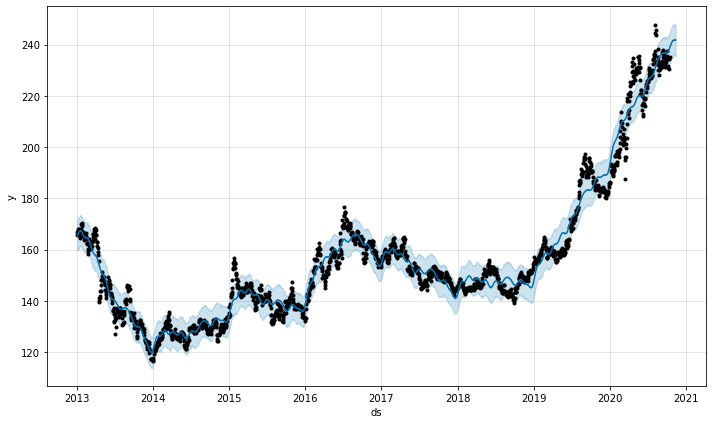

In [101]:
fig = model.plot(forecast)

In [102]:
prophet_pred = forecast[['ds', 'yhat']].tail(30)

In [103]:
prophet_pred

,ds,yhat
1955,2020-10-05,236.972378
1956,2020-10-06,237.092025
1957,2020-10-07,237.246931
1958,2020-10-08,237.333950
1959,2020-10-09,237.578139
1960,2020-10-12,237.995977
1961,2020-10-13,238.217313
1962,2020-10-14,238.468004
1963,2020-10-15,238.643060
1964,2020-10-16,238.965808


## Wizualizacja

In [37]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Cena złota na przestrzeni lat')

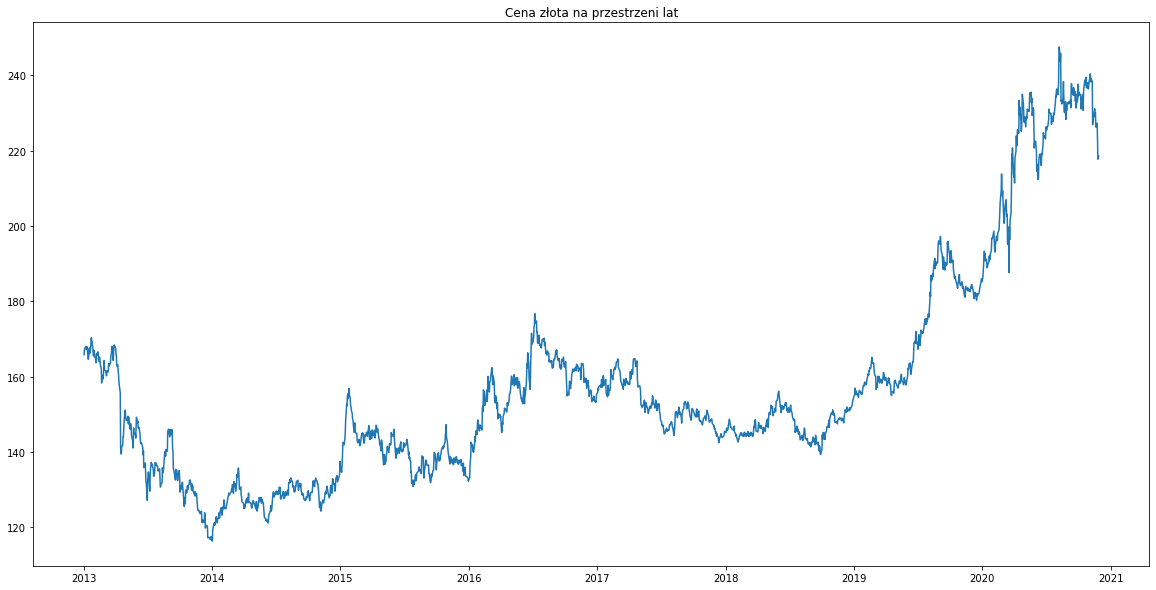

In [49]:
plt.figure(figsize=(20,10))
plt.plot(df.index, df['price'])
plt.title("Cena złota na przestrzeni lat")

In [45]:
df.index.values

array(['2013-01-02T00:00:00.000000000', '2013-01-03T00:00:00.000000000',
       '2013-01-04T00:00:00.000000000', ...,
       '2020-11-25T00:00:00.000000000', '2020-11-26T00:00:00.000000000',
       '2020-11-27T00:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
df_test = df.iloc[-30:]

In [117]:
df_test['Prediction_SVM'] = svm_prediction
df_test['Prediction_LR'] = lr_prediction

<ipython-input-117-cb9310cb8d45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Prediction_SVM'] = svm_prediction
<ipython-input-117-cb9310cb8d45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Prediction_LR'] = lr_prediction


In [118]:
df_test['real'] = df.price > df.price.shift(1)

<ipython-input-118-3435cb180ff0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['real'] = df.price > df.price.shift(1)


In [122]:
df_test['predicted_svm'] = df_test.Prediction_SVM > df_test.Prediction_SVM.shift(1)
df_test['predicted_lr'] = df_test.Prediction_LR > df_test.Prediction_LR.shift(1)

<ipython-input-122-ce5de8a31737>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_svm'] = df_test.Prediction_SVM > df_test.Prediction_SVM.shift(1)
<ipython-input-122-ce5de8a31737>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_lr'] = df_test.Prediction_LR > df_test.Prediction_LR.shift(1)


Text(0.5, 1.0, 'SVM')

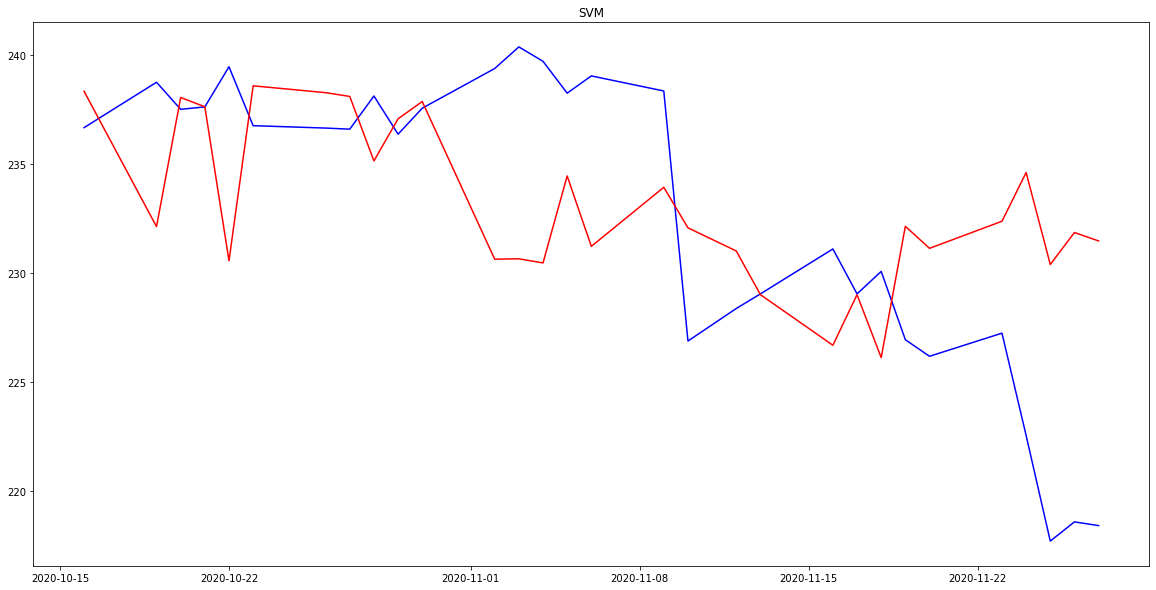

In [123]:
plt.figure(figsize=(20,10))
plt.plot(df_test.index, df_test['price'], 'b')
plt.plot(df_test.index, df_test['Prediction_SVM'], 'r')
plt.title("SVM")

In [126]:
sum(df_test['real'] == df_test['predicted_svm'])/len(df_test)

0.36666666666666664

In [127]:
df_test

,price,Prediction,real,predicted,Prediction_SVM,Prediction_LR,predicted_svm,predicted_lr
date,,,,,,,,
2020-10-16,236.65,238.381684,True,True,238.317428,238.928338,False,False
2020-10-19,238.73,233.399728,True,False,232.114393,241.040971,False,True
2020-10-20,237.49,238.022264,False,True,238.030266,239.781516,True,False
2020-10-21,237.60,237.593799,True,False,237.607452,239.893242,False,True
2020-10-22,239.44,234.954736,True,False,230.547747,241.762110,False,True
2020-10-23,236.74,238.635470,False,True,238.566650,239.019750,True,False
2020-10-26,236.63,238.315883,False,False,238.253265,238.908024,False,False
2020-10-27,236.58,238.136931,False,False,238.079391,238.857239,False,False
2020-10-28,238.10,235.283191,True,False,235.127120,240.401087,False,True


Text(0.5, 1.0, 'LR')

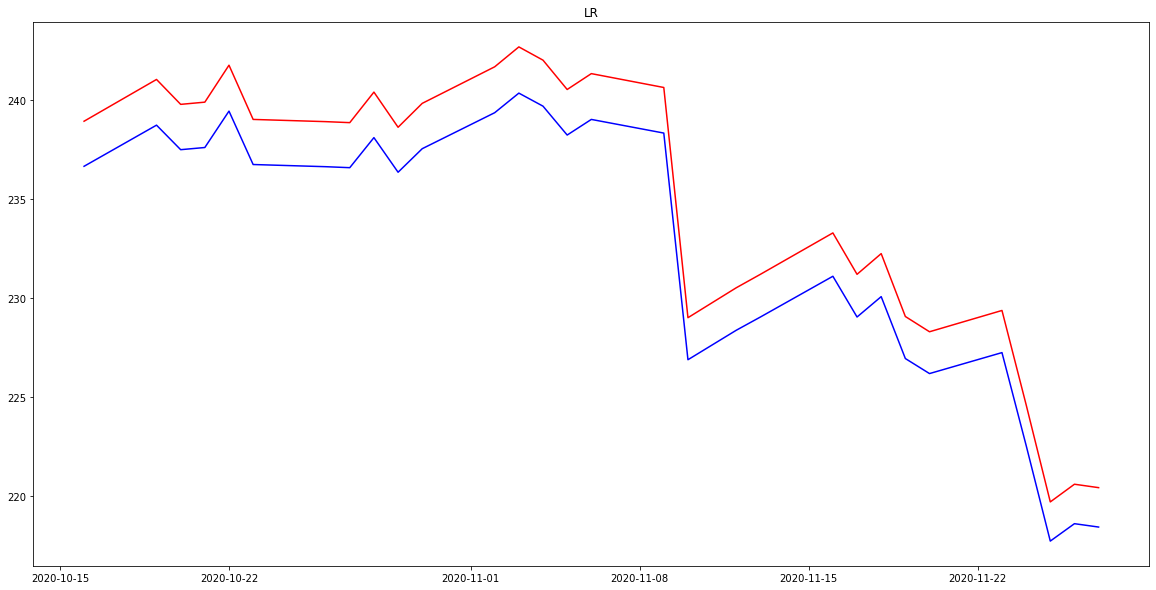

In [125]:
plt.figure(figsize=(20,10))
plt.plot(df_test.index, df_test['price'], 'b')
plt.plot(df_test.index, df_test['Prediction_LR'], 'r')
plt.title("LR")

0.4666666666666667